In [1]:
import numpy as np
import pandas as pd
import pickle  
from sklearn import metrics
import shap
import tensorflow as tf
from tensorflow.keras.models import load_model

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

Results have been obtained by running SHAPForPrediction_tf1.py script

SHAP documentation available at : https://github.com/slundberg/shap

- Check TensorFlow and SHAP version for compatibility 

In [2]:
tf.__version__ , shap.__version__

('1.15.0', '0.31.0')

- Load the dataset file ('file'), the training and test indexes file ('file_to_open') and the model file ('file_model')
- Select the decision horizon Thor ('look_forward')
- Select the sampling time ('step') linked to sequence length Tseq

In [3]:
# Example for the ANN trained on Novice data, in the default case of Tseq = 1s (step = 1) and a prediction horizon Thor = 1 (look_forward = 1)

file = open("./Datasets/DatasetFileMultiClassPred_BothHerders_WrtGoal_Extended_step2","rb")
 
look_forward = 1

# step = ""

model_id = '11032021'
file_id = '002'

directory = './checkpoint/FinalModels/'
file_to_open = open(directory + model_id + '/TrainTestSets_reduced3_indexes_'+file_id,"rb")
file_model = directory + model_id  + '/'+ model_id + file_id + '_reduced3'

- Load the dataset and select the columns referred by 'Labels'

In [4]:
Labels = ['h_t0 rel dist', 'h_t1 rel dist', 'h_t2 rel dist', 'h_t3 rel dist', 'h_t0 rel angle', 'h_t1 rel angle', 
          'h_t2 rel angle', 'h_t3 rel angle', 
          'h_goal rel dist', 't0_goal rel dist', 't1_goal rel dist', 't2_goal rel dist', 't3_goal rel dist',
          'h vel_r' , 't0 vel_r' , 't1 vel_r' , 't2 vel_r' ,  't3 vel_r' , 
          'h acc_r', 't0 acc_r', 't1 acc_r', 't2 acc_r', 't3 acc_r', 
          'h_goal_th', 't0_goal_th', 't1_goal_th', 't2_goal_th', 't3_goal_th', 
          'h_dir_motion', 't0_dir_motion', 't1_dir_motion', 't2_dir_motion', 't3_dir_motion',
          'h_h1 rel dist', 'h_h1 rel angle', 'h1_goal rel dist', 'h1 vel_r', 'h1 acc_r',
          'h1_goal_th', 'h1_dir_motion', 'h1_t0 rel dist', 'h1_t1 rel dist', 'h1_t2 rel dist', 'h1_t3 rel dist', 
          'h1_t0 rel angle', 'h1_t1 rel angle', 'h1_t2 rel angle', 'h1_t3 rel angle','Label']

Labels.insert(0,"Herder_id")
Labels.insert(1,"Trial_id")

In [5]:
Dataset_full_df = pickle.load(file)
file.close()
    
Dataset_df = Dataset_full_df[Labels]

n_features = len(Dataset_df.columns) - 3
print("there are ", n_features," features!")

Dataset = Dataset_df.values

there are  48  features!


- Create the sequences of features and target outputs from the dataset

In [6]:
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY, dataZ = [], [], []
    for i in range(len(dataset)-look_back-look_forward):
        a = dataset[i:(i+look_back), :-1]
        b = dataset[i:(i+look_back+look_forward), -1]
        dataX.append(a)
        dataY.append(dataset[i + look_back + look_forward, -1])
        dataZ.append(b)
    return dataX, dataY, dataZ

In [7]:
look_back = 25 # Sequence length

sequences, sequences_labels, targets = [], [], []

# A sequence can refer to only one Herder ID and one Trial ID

herders_tot = int(max(Dataset[:,0])) + 1
trial_tot = int(max(Dataset[:,1])) + 1

for herder_id in range(herders_tot):
    for trial_id in range(trial_tot):
        Dtst = Dataset_df[(Dataset_df["Herder_id"]==herder_id) & (Dataset_df["Trial_id"]==trial_id)].values[:,2:]
        seq, tar, seq_lbl = create_dataset(Dtst, look_back, look_forward)
        sequences = sequences + seq
        targets = targets + tar
        sequences_labels = sequences_labels + seq_lbl

- Select from the total available samples the ones used for training and test 

In [8]:
indexes_data = pickle.load(file_to_open)
file_to_open.close()

test_index = indexes_data[1]

sequences_array = np.array(sequences)
sequences_labels_array = np.array(sequences_labels)
targets_array = np.array(targets)

X_test = sequences_array[test_index]
y_test = targets_array[test_index]
 
dummies_test = pd.get_dummies(y_test)

# test = X_test
# test_target = dummies_test.values

z_test_index = test_index

# Check to which category the test samples belong to

Note that  a "sequence of labels" has 26 elements being the labels of the 25 timestamps in the sequence and the 26th 
timestep corresponding to the target value to be predicted

In [9]:
Z_test = []
Z_test = sequences_labels_array[z_test_index]

In [10]:
test_SameSeq_SameTar_indexes = []         # indexes of sequences/targets with all equal labels 
test_SameSeq_DiffTar_indexes = []         # indexes of sequences with equal labels but different target
test_DiffSeq_SameTar_indexes = []         # indexes of sequences with different labels but 25th label equale to the target
test_DiffSeq_DiffTar_indexes = []         # indexex of sequences/targets with all different labels


for i in range(len(Z_test)): 
    
    arr = Z_test[i]

    result_SameSeq_SameTar = np.all(arr == arr[0])
    result_SameSeq_DiffTar = np.all(arr[:-1] == arr[0]) & (arr[-1] != arr[-2])
    result_DiffSeq_SameTar = np.any(arr[:-1] != arr[0]) & (arr[-1] == arr[-2])
    result_DiffSeq_DiffTar = np.any(arr[:-1] != arr[0]) & (arr[-1] != arr[-2])
    
    
    if result_SameSeq_SameTar:
        test_SameSeq_SameTar_indexes.append(i)
    if result_SameSeq_DiffTar:
        test_SameSeq_DiffTar_indexes.append(i)
    if result_DiffSeq_SameTar:
        test_DiffSeq_SameTar_indexes.append(i)
    if result_DiffSeq_DiffTar:
        test_DiffSeq_DiffTar_indexes.append(i)
    

In [11]:
print("Non trasitioning and non switching sequences %0.2f" %(len(test_SameSeq_SameTar_indexes)/len(test_index)*100))
print("Non Transitioning and switching sequences %0.2f" %(len(test_SameSeq_DiffTar_indexes)/len(test_index)*100))
print("Transitioning and non switching sequences %0.2f" %(len(test_DiffSeq_SameTar_indexes)/len(test_index)*100))
print("Transitioning and switching sequences %0.2f" %(len(test_DiffSeq_DiffTar_indexes)/len(test_index)*100))

Non trasitioning and non switching sequences 61.05
Non Transitioning and switching sequences 1.30
Transitioning and non switching sequences 37.45
Transitioning and switching sequences 0.20


# Compute performance metrics of the ANN

- Select the test set

In [12]:
# test_set = X_test
# test_set_target = dummies_test.values

- Load the trained ANN

In [13]:
model = load_model(file_model)

- Use the trained ANN on the test set and Compute metrics for the trained ANN

------ Accuracy: 97.65%
Macro-Precision: 97.34%
-- Macro-Recall: 97.73%
------ Macro-F1: 97.52%
---- KappaScore: 96.92%


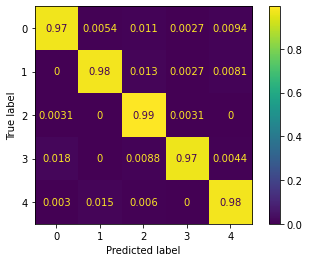

In [14]:
test_preds = model.predict(X_test)

predicted_classes = np.argmax(test_preds,axis=1)
expected_classes = np.argmax(dummies_test.values,axis=1)
correct = metrics.accuracy_score(expected_classes,predicted_classes)

print("------ Accuracy: %.2f%%" % (correct*100))

precision_recall_f1 = metrics.precision_recall_fscore_support(expected_classes,predicted_classes)

precision, recall, f1 = 0, 0, 0

for i in range (5): 
    precision = precision + precision_recall_f1[0][i]
    recall = recall + precision_recall_f1[1][i]
    f1 = f1 + precision_recall_f1[2][i]

print("Macro-Precision: %.2f%%" % (precision*100 / 5))
print("-- Macro-Recall: %.2f%%" % (recall*100 / 5))
print("------ Macro-F1: %.2f%%" % (f1*100 /5))

kappascore = metrics.cohen_kappa_score(expected_classes, predicted_classes)
print("---- KappaScore: %.2f%%" % (kappascore*100))

confusionMatrix = metrics.confusion_matrix(expected_classes, predicted_classes, normalize='true')
metrics.ConfusionMatrixDisplay(confusionMatrix).plot()

# Load and print the SHAP values' file 

In [15]:
file_name_shap = file_model+'_ShapVal'

with open(file_name_shap,'rb') as file:
    shap_values = pickle.load(file)
    
shap_values = shap_values[0]

In [16]:
# shap.initjs()   # uncomment this line to display SHAP plots 

- For each class, compute the mean of shap values associated to each input features and display the top 10 [https://github.com/slundberg/shap/issues/632]

In [17]:
feat_list = []

for class_id in range(5):
    vals = np.abs(shap_values[class_id]).mean(0)
    feature_importance = pd.DataFrame(list(zip(Labels[2:-1], sum(vals))), columns=['var','feature_importance_vals_class'+str(class_id)])
    feature_importance.sort_values(by=['feature_importance_vals_class'+str(class_id)], ascending=False,inplace=True)
    feat_list.append(feature_importance.values[:10,0])
    print('\n class ', class_id)
    print(feature_importance.values[:10,0],"\n")



 class  0
['h_t0 rel dist' 'h vel_r' 'h_t1 rel dist' 'h_t3 rel dist' 'h acc_r'
 't0 acc_r' 't1 acc_r' 'h_t2 rel dist' 't3 acc_r' 't1 vel_r'] 


 class  1
['h_t0 rel dist' 't0 acc_r' 'h vel_r' 'h1_t0 rel dist' 'h_t1 rel dist'
 'h_t3 rel dist' 't0 vel_r' 't0_goal rel dist' 't1 acc_r' 'h1_t3 rel dist'] 


 class  2
['h_t1 rel dist' 't1 acc_r' 'h1_t1 rel dist' 'h vel_r' 't0 acc_r'
 'h_t3 rel dist' 'h_t0 rel dist' 't1 vel_r' 'h acc_r' 'h_t2 rel dist'] 


 class  3
['h_t2 rel dist' 't2 acc_r' 'h vel_r' 'h1_t2 rel dist' 'h_t0 rel dist'
 't3 vel_r' 'h_t1 rel dist' 't2 vel_r' 'h acc_r' 'h_t3 rel dist'] 


 class  4
['h_t3 rel dist' 't3 acc_r' 'h vel_r' 'h_t0 rel dist' 'h_t2 rel dist'
 'h_t1 rel dist' 'h1_t3 rel dist' 't3_goal rel dist' 'h acc_r' 't0 acc_r'] 

